In [1]:
# Predict the green signal using just the red; the residual should be real!


# Get data

In [2]:
import zarr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
import os

In [3]:
project_dir = r"Y:\shared_projects\wbfm\dlc_stacks\Charlie-worm3-long"

fname = r"Y:\shared_projects\wbfm\dlc_stacks\Charlie-worm3-long\4-traces\retracked_neurons\red_traces.h5"
red_dat = pd.read_hdf(fname)

fname = r"Y:\shared_projects\wbfm\dlc_stacks\Charlie-worm3-long\4-traces\retracked_neurons\green_traces.h5"
green_dat = pd.read_hdf(fname)

fname = r"Y:\shared_projects\wbfm\dlc_stacks\Charlie-worm3-long\3-tracking\manual_tracking\worm3_neurons.xlsx"
behavior_dat = pd.read_excel(fname, sheet_name='behavior')

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

import matplotlib
matplotlib.rc('font', **font)

# Convert data into proper format

Use a histogram version of the red channel, as well as z information

In [4]:
name = 'neuron4207'
neuron_id = 'RMED'

z_dat = red_dat[name]['z_seg']
all_vals_red = red_dat[name]['all_values']
all_vals_green = green_dat[name]['all_values']

to_skip_red = [np.isscalar(v) for v in all_vals_red]
to_skip_green = [np.isscalar(g) for g in all_vals_green]
to_skip = [r or g for r, g in zip(to_skip_red, to_skip_green)]

hist_num_bins = 64

# edges = np.arange(13, 500, 5)
edges = np.linspace(100, 500, hist_num_bins)

all_hist_red = [np.histogram(v[0], bins=edges)[0] for v, bad in zip(all_vals_red, to_skip) if not bad]
# for v in all_vals_red:
#     if not np.isscalar(v):
#         all_hist_red.append(np.histogram(v[0]))

all_hist_green = [np.histogram(v[0], bins=edges)[0] for v, bad in zip(all_vals_green, to_skip) if not bad]
background_per_pix = 14
g_trace = np.array(green_dat[name]['brightness']) - background_per_pix*np.array(green_dat[name]['volume'])

r_trace = np.array(green_dat[name]['brightness']) - background_per_pix*np.array(green_dat[name]['volume'])

# all_hist_green = []
# for v in all_vals_green:
#     if not np.isscalar(v):
#         all_hist_green.append(np.histogram(v[0]))

In [5]:
np.where(to_skip)

(array([  35,  118,  125,  126,  168,  200,  321, 1059, 1147, 1401],
       dtype=int64),)

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


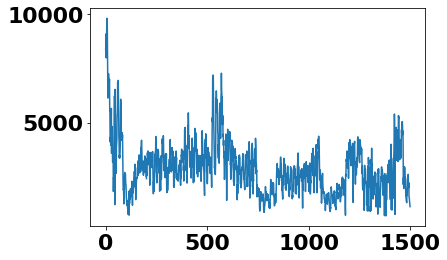

In [6]:
plt.plot(g_trace)

## Create the actual data

In [7]:
# # For now, hand-made normalization
# X = []
# for z, hist in zip(z_dat, all_hist_red):
#     X.append(np.hstack([z / 20.0 , hist / 50.0]))
    

from sklearn.preprocessing import StandardScaler
s = StandardScaler()
# For now, hand-made normalization
X = []
for z, hist in zip(z_dat, all_hist_red):
    hist = hist.reshape(-1,1)
    
    X.append(np.hstack([z / 20.0 , np.squeeze(s.fit(hist).transform(hist))]))

In [112]:
norm_factor = np.nanmax(g_trace)
print(norm_factor)

# Y = [g/norm_factor for g, bad in zip(g_trace, to_skip) if not bad]

norm_factor = np.nanmax(r_trace)
Y = [r/norm_factor for r, bad in zip(r_trace, to_skip) if not bad]

9826.0


NameError: name 'r_trace' is not defined

In [9]:
# Remove nan values
to_remove = []
for i, (x, y) in enumerate(zip(X, Y)):
    if any(np.isnan(x)) or np.isnan(y):
        to_remove.append(i)

to_remove.reverse()
[X.pop(i) for i in to_remove]
[Y.pop(i) for i in to_remove]

print(f"Removed {len(to_remove)} entries")

Removed 10 entries


In [10]:
np.where(np.isnan(X))

(array([], dtype=int64), array([], dtype=int64))

# Define a NN

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cuda device


In [100]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(hist_num_bins, 1) # Target is a single value
        )
#         self.linear_relu_stack = nn.Sequential(
#             nn.Linear(hist_num_bins, 16),
#             nn.ReLU(),
#             nn.Linear(16, 16),
#             nn.ReLU(),
#             nn.Linear(16, 16),
#             nn.ReLU(),
#             nn.Linear(16, 1) # Target is a single value
#         )

    def forward(self, x):
        logits = torch.squeeze(self.linear_relu_stack(x))
        return logits

In [101]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=64, out_features=1, bias=True)
  )
)


# Build training set

In [102]:
learning_rate = 1e-8
batch_size = 128
epochs = 5

# Initialize the loss function
loss_fn = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [103]:
from torch.utils.data import DataLoader

all_data = list([[x, y] for x, y in zip(X, Y)])
sz = len(all_data)
train_test_split = int(sz*0.7)
print(sz)

training_data = all_data[:train_test_split].copy()
test_data = all_data[train_test_split:].copy()

train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

1480


In [104]:
for x, y in train_dataloader:
#     print(i)
    X_tmp = x.float().to(device)
    untrained_prediction = model(X_tmp)
    print("untrained_prediction for batch 1: ", untrained_prediction[:5])
    print("Shape of predictions: ")
    print(untrained_prediction.shape, y.shape)
    print("Loss: ")
    print(loss_fn(untrained_prediction, y.float().to(device)))
    break

untrained_prediction for batch 1:  tensor([-0.3885,  0.1546, -0.3594, -0.3681, -0.2857], device='cuda:0',
       grad_fn=<SliceBackward>)
Shape of predictions: 
torch.Size([128]) torch.Size([128])
Loss: 
tensor(0.4501, device='cuda:0', grad_fn=<MseLossBackward>)


In [105]:
# for x, y in train_dataloader:
#     print(np.where(torch.isnan(x)))

# Actually train

In [106]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X.float().to(device))
        loss = loss_fn(pred, y.float().to(device))

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 10 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X.float().to(device))
            test_loss += loss_fn(pred, y.float().to(device)).item()
#             correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Avg loss: {test_loss:>8f} \n")

In [107]:
torch.autograd.set_detect_anomaly(True)
for _ in tqdm(range(epochs)):
    train_loop(train_dataloader, model, loss_fn, optimizer)

  0%|          | 0/5 [00:00<?, ?it/s]

loss: 0.441286  [    0/ 1036]
loss: 0.429798  [    0/ 1036]
loss: 0.416893  [    0/ 1036]
loss: 0.421777  [    0/ 1036]
loss: 0.449267  [    0/ 1036]


In [108]:
test_loop(test_dataloader, model, loss_fn)

Test Error: 
 Avg loss: 0.395252 



# Predict

In [109]:
# model(torch.tensor(X[0]).float().to(device))
# model.to('cpu')
# y_pred = np.array([model(torch.tensor(x).float().to(device)) for x in X])
y_pred = np.array([model(torch.tensor(x).float()) for x in X])

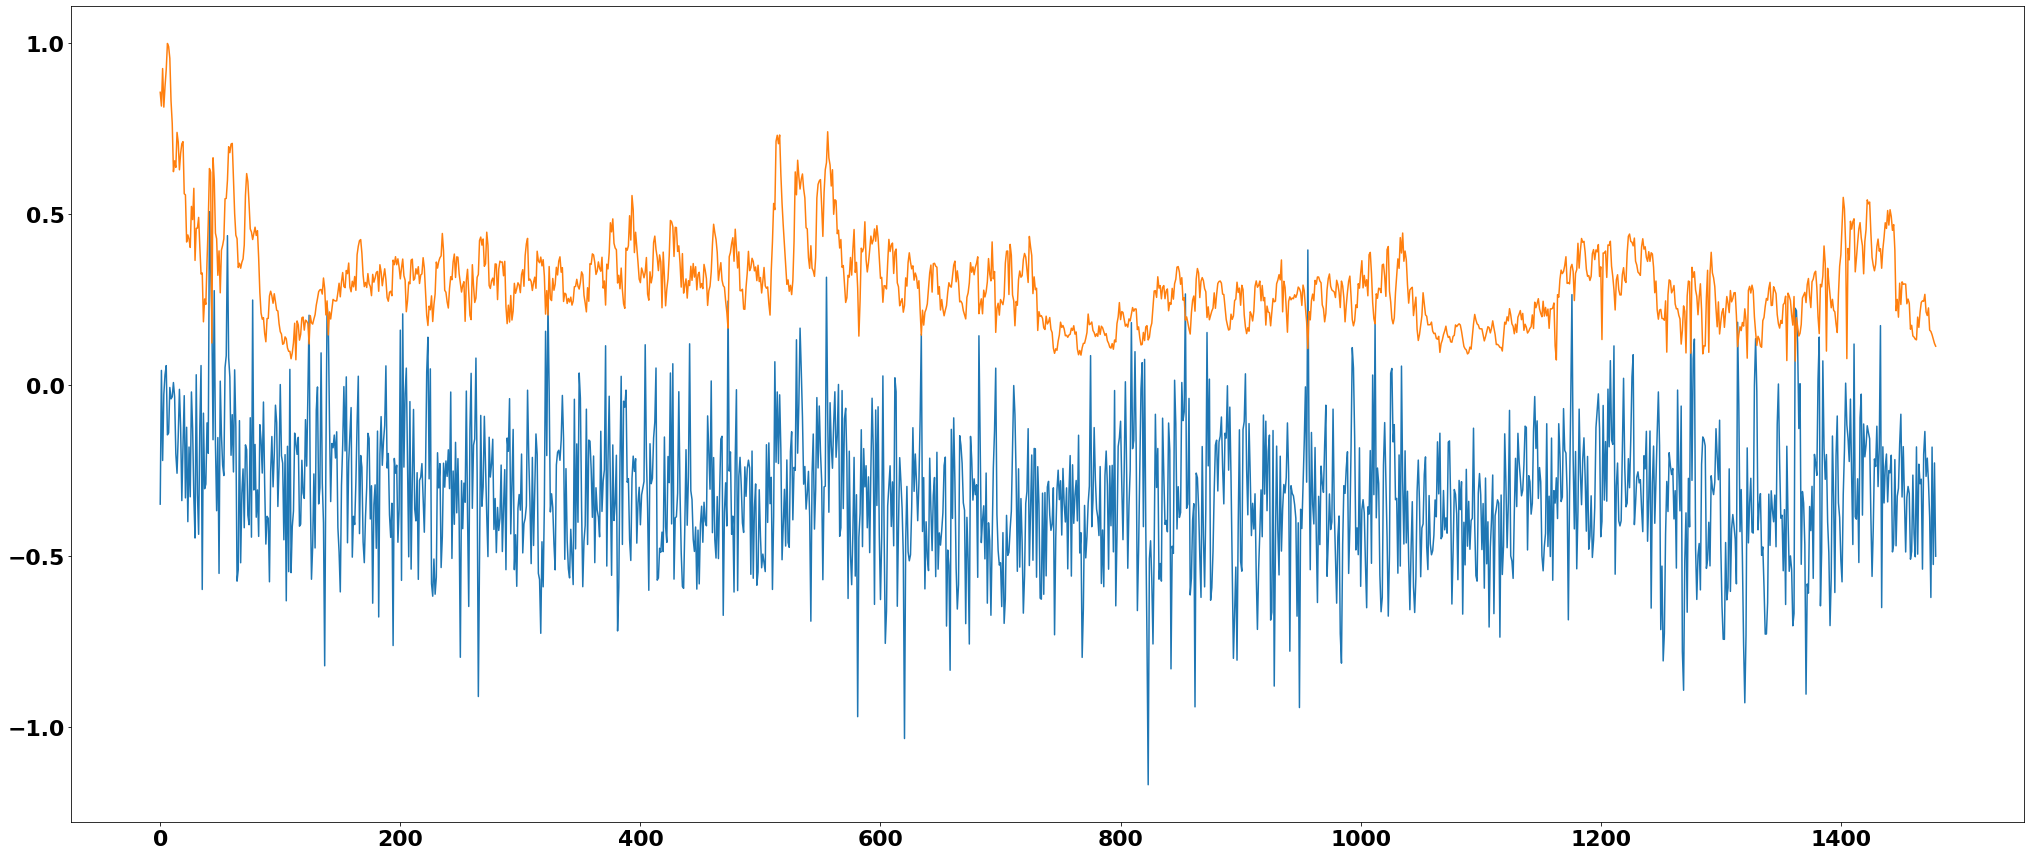

In [110]:
plt.figure(figsize=(35,15))
plt.plot(y_pred, label='network output')
plt.plot(Y, label='target')


In [111]:
# y_pred

# Other dataset for formatting help

In [24]:
# import torch
# from torch.utils.data import Dataset
# from torchvision import datasets
# from torchvision.transforms import ToTensor
# import matplotlib.pyplot as plt


# training_data = datasets.FashionMNIST(
#     root="data",
#     train=True,
#     download=True,
#     transform=ToTensor()
# )

# test_data = datasets.FashionMNIST(
#     root="data",
#     train=False,
#     download=True,
#     transform=ToTensor()
# )

In [25]:
# training_data